In [1]:
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Dropout
from sklearn.model_selection import train_test_split as splitter
import cProfile
import pstats
import os
import sys
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from datetime import datetime
from matplotlib import pyplot as plt
from matplotlib import dates as md

print("Librerie importate con successo")

Librerie importate con successo


In [2]:
data = pd.read_csv('../Datasets/kdd_prediction.csv', delimiter=',',
                       dtype={'protocol_type': str, 'service': str, 'flag': str, 'result': str})

print("Dataset importato con successo")

Dataset importato con successo


Total :  13451
Normal :  7500
Malicious :  5951


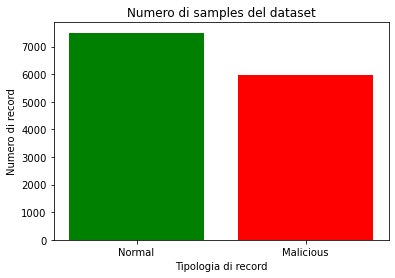

In [3]:
#Effettuo il plot del dataset

total_flows_count = data["result"].count()
normal_flows_count = len(data[data.result == "normal"])
anomaly_flows_count = len(data[data.result != "normal"])

print("Total : ",total_flows_count)
print("Normal : ",normal_flows_count)
print("Malicious : ",anomaly_flows_count)

# x-coordinates of left sides of bars  
left = [1, 1.5] 
  
# heights of bars 
height = [normal_flows_count, anomaly_flows_count] 
  
# labels for bars 
tick_label = ['Normal', 'Malicious'] 
  
# bar chart
plt.bar(left, height, tick_label = tick_label, 
        width = 0.4, color = ['green', 'red']) 
  
# Rinominazione asse x 
plt.xlabel('Tipologia di record') 
# Rinominazione asse y 
plt.ylabel('Numero di record') 
# Titolo
plt.title('Numero di samples del dataset') 
  
plt.show() 

In [4]:
#Funzioni utili preprocessing

#ottiene una service_list dal file service.txt prelevando ogni riga e inserendola in una lista
def get_service_list(dirname='list', filename='service_mio.txt'):
    print('Getting service list...')
    with open(os.path.join(dirname, filename), 'r') as service:
        service_list = service.read().split('\n')
    return service_list

#ottiene una flag_list dal file flag.txt prelevando ogni riga e inserendola in una lista
def get_flag_list(dirname='list', filename='flag_mio.txt'):
    print('Getting flag list...')
    with open(os.path.join(dirname, filename), 'r') as flag:
        flag_list = flag.read().split('\n')
    return flag_list

In [5]:
service_list = get_service_list(dirname='list', filename='service_mio.txt')
flag_list = get_flag_list(dirname='list', filename='flag_mio.txt')

print('Replacing protocol_type values to numeric...')
data.protocol_type.replace(['tcp', 'udp', 'icmp'], range(3), inplace=True)

print('Replacing service values to numeric...')
data.service.replace(service_list, range(len(service_list)), inplace=True)

print('Replacing flag values to numeric...')
data.flag.replace(flag_list, range(len(flag_list)), inplace=True)
data.result.replace(['dos','normal','probe','r2l','u2r'], range(5), inplace=True)

Getting service list...
Getting flag list...
Replacing protocol_type values to numeric...
Replacing service values to numeric...
Replacing flag values to numeric...


In [6]:
sc = MinMaxScaler()
enc = OneHotEncoder(categories=[range(3), range(len(service_list)), range(len(flag_list))])
num_desc = data.loc[:, ['duration', 'src_bytes', 'dst_bytes']].describe()

label, df_label = [], []
    
label = data['result'].copy().values.reshape((data.shape[0], 1))
df_label = pd.DataFrame(label)
data.drop(['result'], axis=1, inplace=True)   

attr_name = ['duration', '', '', '', 'src_bytes', 'dst_bytes']

for i in ['duration', 'src_bytes', 'dst_bytes']:
    iqr = (num_desc[i].values[6] - num_desc[i].values[4])
    std = num_desc[i].values[6] + iqr * 1.5  # IQR upper fence = Q3 + 1.5 * IQR
    if std == 0:
        data[i] = data[i].map(lambda x: 1 if x > 0 else 0)
    else:
        data[i] = data[i].map(lambda x: std if x > std else x)
sc.fit(data[['duration', 'src_bytes', 'dst_bytes']].values)
data[['duration', 'src_bytes', 'dst_bytes']] = sc.transform(data[['duration', 'src_bytes', 'dst_bytes']].values)

print('Conversione feature "count" in linguaggio macchina . . .')
sc.fit(data[['count']].values.astype(np.float32))
data[['count']] = sc.transform(data[['count']].values.astype(np.float32))

print('Conversione indici 1,2,3 in linguaggio macchina . . .')
enc.fit(data[['protocol_type','service','flag']].values)
one_hot_arr = enc.transform(data[['protocol_type','service','flag']].values).toarray()

print('Rimuovo le features di indici 1,2,3 e concateno un hot encoder array')
data.drop(['protocol_type','service','flag'], axis=1, inplace=True)
data_final = np.concatenate((data.values, one_hot_arr, df_label), axis=1)
data_final = pd.DataFrame(data_final)

print("")
print("")
print('Final shape of data:', data_final.shape)
print("")
print("")

Conversione feature "count" in linguaggio macchina . . .
Conversione indici 1,2,3 in linguaggio macchina . . .
Rimuovo le features di indici 1,2,3 e concateno un hot encoder array


Final shape of data: (13451, 95)




In [7]:
y = data_final[94]
x = data_final.drop([94], axis=1)
profile = cProfile.Profile()
x_train, x_test, y_train, y_test = splitter(x, y, test_size=0.3, random_state=32)

Il dataset per il train è composto da :  9415 record
Il dataset per il train è composto da :  4186 anomalie
Il dataset per il train è composto da :  5229 record normali


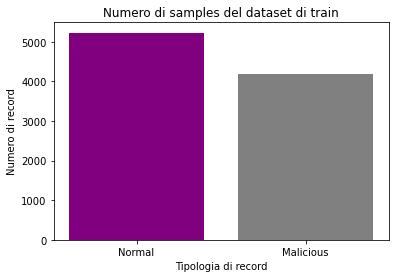

In [8]:
num_train = len(x_train)
num_train_normal = 0

print("Il dataset per il train è composto da : ",num_train,"record")

for i in y_train:
    if(i == 1):
        num_train_normal = num_train_normal + 1
    
        
num_train_anomaly = num_train - num_train_normal

print("Il dataset per il train è composto da : ",num_train_anomaly,"anomalie")
print("Il dataset per il train è composto da : ",num_train_normal,"record normali")

left = [1, 1.5] 
  
# heights of bars 
height = [num_train_normal, num_train_anomaly] 
  
# labels for bars 
tick_label = ['Normal', 'Malicious'] 
  
# bar chart
plt.bar(left, height, tick_label = tick_label, 
        width = 0.4, color = ['purple', 'grey']) 
  
# Rinominazione asse x 
plt.xlabel('Tipologia di record') 
# Rinominazione asse y 
plt.ylabel('Numero di record') 
# Titolo
plt.title('Numero di samples del dataset di train') 
  
plt.show() 

Il dataset per il test è composto da :  4036 record
Il dataset per il test è composto da :  1765 anomalie
Il dataset per il test è composto da :  2271 record normali


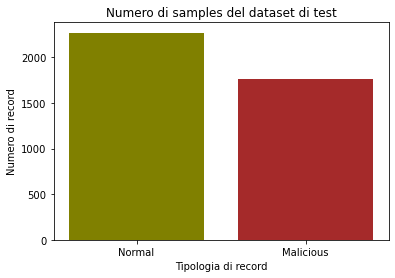

In [9]:
num_test = len(x_test)
num_test_normal = 0
num_test_dos = 0
num_test_r2l = 0
num_test_u2r = 0
num_test_probe = 0

print("Il dataset per il test è composto da : ",num_test,"record")

for i in y_test:
    if(i == 0):
        num_test_dos = num_test_dos + 1
    if(i == 1):
        num_test_normal = num_test_normal + 1
    if(i == 2):
        num_test_probe = num_test_probe + 1
    if(i == 3):
        num_test_r2l = num_test_r2l + 1
    if(i == 4):
        num_test_u2r = num_test_u2r + 1
        
num_test_anomaly = num_test - num_test_normal

print("Il dataset per il test è composto da : ",num_test_anomaly,"anomalie")
print("Il dataset per il test è composto da : ",num_test_normal,"record normali")

left = [1, 1.5] 
  
# heights of bars 
height = [num_test_normal, num_test_anomaly] 
  
# labels for bars 
tick_label = ['Normal', 'Malicious'] 
  
# bar chart
plt.bar(left, height, tick_label = tick_label, 
        width = 0.4, color = ['Olive', 'brown']) 
  
# Rinominazione asse x 
plt.xlabel('Tipologia di record') 
# Rinominazione asse y 
plt.ylabel('Numero di record') 
# Titolo
plt.title('Numero di samples del dataset di test') 
  
plt.show() 

Il dataset per il test è composto da :  1495 record dos
Il dataset per il test è composto da :  138 record probe
Il dataset per il test è composto da :  116 record r2l
Il dataset per il test è composto da :  16 record u2r


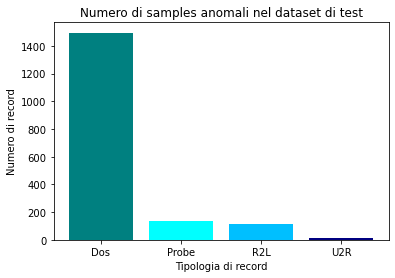

In [10]:
print("Il dataset per il test è composto da : ",num_test_dos,"record dos")
print("Il dataset per il test è composto da : ",num_test_probe,"record probe")
print("Il dataset per il test è composto da : ",num_test_r2l,"record r2l")
print("Il dataset per il test è composto da : ",num_test_u2r,"record u2r")

left = [1, 1.5, 2, 2.5] 
  
# heights of bars 
height = [num_test_dos, num_test_probe, num_test_r2l, num_test_u2r] 
  
# labels for bars 
tick_label = ['Dos', 'Probe', "R2L", "U2R"] 
  
# bar chart
plt.bar(left, height, tick_label = tick_label, 
        width = 0.4, color = ['teal', 'cyan','deepskyblue','navy']) 
  
# Rinominazione asse x 
plt.xlabel('Tipologia di record') 
# Rinominazione asse y 
plt.ylabel('Numero di record') 
# Titolo
plt.title('Numero di samples anomali nel dataset di test') 
  
plt.show() 

In [11]:
profile.enable()
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

val_indices = 200
x_val = x_train[-val_indices:]
y_val = y_train[-val_indices:]


In [12]:
model = Sequential()
model.add(Dense(1024, activation='relu', input_dim=x_train.shape[1], kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              97280     
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              1

In [13]:
history=model.fit(x_train,
          y_train,
          epochs=15,
          batch_size=512,
          validation_data=(x_val, y_val)
         )

Epoch 1/15
19/19 [==============================] - 3s 169ms/step - loss: 6.0449 - accuracy: 0.5955 - val_loss: 3.6824 - val_accuracy: 0.9500
Epoch 2/15
19/19 [==============================] - 3s 162ms/step - loss: 3.1461 - accuracy: 0.9337 - val_loss: 2.4353 - val_accuracy: 0.9650
Epoch 3/15
19/19 [==============================] - 3s 158ms/step - loss: 2.1700 - accuracy: 0.9394 - val_loss: 1.6333 - val_accuracy: 0.9650
Epoch 4/15
19/19 [==============================] - 3s 155ms/step - loss: 1.4317 - accuracy: 0.9449 - val_loss: 1.0384 - val_accuracy: 0.9650
Epoch 5/15
19/19 [==============================] - 3s 156ms/step - loss: 0.9189 - accuracy: 0.9500 - val_loss: 0.6276 - val_accuracy: 0.9700
Epoch 6/15
19/19 [==============================] - 3s 156ms/step - loss: 0.6048 - accuracy: 0.9535 - val_loss: 0.3989 - val_accuracy: 0.9850
Epoch 7/15
19/19 [==============================] - 3s 164ms/step - loss: 0.4011 - accuracy: 0.9652 - val_loss: 0.4557 - val_accuracy: 0.9650
Epoch 

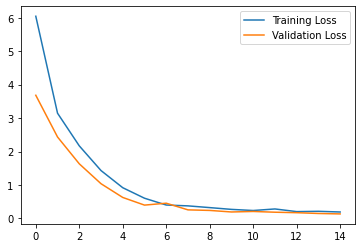

In [14]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

In [15]:
y_pred = model.predict(x_test)
profile.disable()
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)
profile.dump_stats('output.prof')
stream = open('result/keras_kdd_profiling.txt', 'w')
stats = pstats.Stats('output.prof', stream=stream)
stats.sort_stats('cumtime')
stats.print_stats()
os.remove('output.prof')

Il classificatore ha predetto in totale 1540 record Dos di cui 1494 corretti(TP), 46 predetti erroneamente(FP), 1 record Dos reali predetti in altri attacchi (FN)

Il classificatore ha predetto in totale 2285 record Normali di cui 2247 corretti(TP), 38 predetti erroneamente(FP), 24 record Normali reali predetti in altri attacchi (FN)

Il classificatore ha predetto in totale 88 record Probe di cui 83 corretti(TP), 5 predetti erroneamente(FP), 55 record Probe reali predetti in altri attacchi (FN)

Il classificatore ha predetto in totale 123 record R2L di cui 97 corretti(TP), 26 predetti erroneamente(FP), 19 record R2L reali predetti in altri attacchi (FN)

Il classificatore ha predetto in totale 0 record U2R di cui 0 corretti(TP), 0 predetti erroneamente(FP), 16 record U2R reali predetti in altri attacchi (FN)


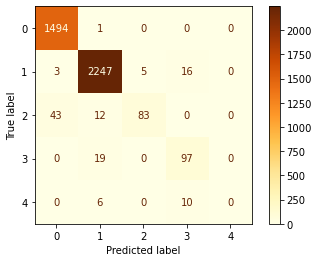

0 = Dos / 1 = Normal / 2 = Probe / 3 = r2l / 4 = u2r

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1495
           1       0.98      0.99      0.99      2271
           2       0.94      0.60      0.73       138
           3       0.79      0.84      0.81       116
           4       0.00      0.00      0.00        16

    accuracy                           0.97      4036
   macro avg       0.74      0.69      0.70      4036
weighted avg       0.97      0.97      0.97      4036



C:\Users\39331\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
conf_matrix = confusion_matrix(y_test, y_pred)

# 0 = Dos / 1 = Normal / 2 = Probe / 3 = r2l / 4 = u2r

print("Il classificatore ha predetto in totale", 
      conf_matrix[0][0]+conf_matrix[1][0]+conf_matrix[2][0]+conf_matrix[3][0]+conf_matrix[4][0],
      "record Dos di cui",conf_matrix[0][0],"corretti(TP),",
      conf_matrix[1][0]+conf_matrix[2][0]+conf_matrix[3][0]+conf_matrix[4][0],
      "predetti erroneamente(FP),",
      conf_matrix[0][1]+conf_matrix[0][2]+conf_matrix[0][3]+conf_matrix[0][4],
      "record Dos reali predetti in altri attacchi (FN)"
     )
print("")
print("Il classificatore ha predetto in totale", 
      conf_matrix[0][1]+conf_matrix[1][1]+conf_matrix[2][1]+conf_matrix[3][1]+conf_matrix[4][1],
      "record Normali di cui",conf_matrix[1][1],"corretti(TP),",
      conf_matrix[0][1]+conf_matrix[2][1]+conf_matrix[3][1]+conf_matrix[4][1],
      "predetti erroneamente(FP),",
      conf_matrix[1][0]+conf_matrix[1][2]+conf_matrix[1][3]+conf_matrix[1][4],
      "record Normali reali predetti in altri attacchi (FN)"
     )
print("")
print("Il classificatore ha predetto in totale", 
      conf_matrix[0][2]+conf_matrix[1][2]+conf_matrix[2][2]+conf_matrix[3][2]+conf_matrix[4][2],
      "record Probe di cui",conf_matrix[2][2],"corretti(TP),",
      conf_matrix[0][2]+conf_matrix[1][2]+conf_matrix[3][2]+conf_matrix[4][2],
      "predetti erroneamente(FP),",
      conf_matrix[2][0]+conf_matrix[2][1]+conf_matrix[2][3]+conf_matrix[2][4],
      "record Probe reali predetti in altri attacchi (FN)"
     )
print("")
print("Il classificatore ha predetto in totale", 
      conf_matrix[0][3]+conf_matrix[1][3]+conf_matrix[2][3]+conf_matrix[3][3]+conf_matrix[4][3],
      "record R2L di cui",conf_matrix[3][3],"corretti(TP),",
      conf_matrix[0][3]+conf_matrix[1][3]+conf_matrix[2][3]+conf_matrix[4][3],
      "predetti erroneamente(FP),",
      conf_matrix[3][0]+conf_matrix[3][1]+conf_matrix[3][2]+conf_matrix[3][4],
      "record R2L reali predetti in altri attacchi (FN)"
     )
print("")
print("Il classificatore ha predetto in totale", 
      conf_matrix[0][4]+conf_matrix[1][4]+conf_matrix[2][4]+conf_matrix[3][4]+conf_matrix[4][4],
      "record U2R di cui",conf_matrix[4][4],"corretti(TP),",
      conf_matrix[0][4]+conf_matrix[1][4]+conf_matrix[2][4]+conf_matrix[3][4],
      "predetti erroneamente(FP),",
      conf_matrix[4][0]+conf_matrix[4][1]+conf_matrix[4][2]+conf_matrix[4][3],
      "record U2R reali predetti in altri attacchi (FN)"
     )

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

disp = disp.plot(cmap='YlOrBr')

plt.show()
print("0 = Dos / 1 = Normal / 2 = Probe / 3 = r2l / 4 = u2r")
print("")
print(classification_report(y_test, y_pred))

### 0 Anomaly / 1 Normal ###


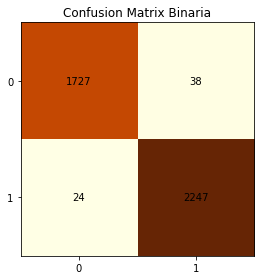

          predicted labels  


In [24]:
#Calcolo a posteriori la rispettiva matrice di confusione binaria associata alla precedente

#num_test_normal / num_test_dos etc . . .
# 1 è normal mentre 0 2 3 4 sono anomalies

#Record normali classificati come normali (TP)

true_positive = conf_matrix[1][1]

#record anomali classificati come anomali (TN)

true_negative = (conf_matrix[0][0] + conf_matrix[0][2] + conf_matrix[0][3] + conf_matrix[0][4] +
                + conf_matrix[2][0] + conf_matrix[2][2] + conf_matrix[2][3] + conf_matrix[2][4] 
                + conf_matrix[3][0] + conf_matrix[3][2] + conf_matrix[3][3] + conf_matrix[3][4] 
                + conf_matrix[4][0] + conf_matrix[4][2] + conf_matrix[4][3] + conf_matrix[4][4])
            
#record normali classificati come anomali (FN)

false_negative = conf_matrix[1][0] + conf_matrix[1][2] + conf_matrix[1][3] + conf_matrix[1][4]

#record anomali classificati come normali (FP)

false_positive = conf_matrix[0][1] + conf_matrix[2][1] + conf_matrix[3][1] + conf_matrix[4][1]

indici_riga_colonna = ['0','1']


values = np.array([[true_negative, false_positive],
                   [false_negative, true_positive]])

fig, ax = plt.subplots()
im = ax.imshow(values, cmap='YlOrBr')

ax.set_xticks(np.arange(len(indici_riga_colonna)))
ax.set_yticks(np.arange(len(indici_riga_colonna)))

ax.set_xticklabels(indici_riga_colonna)
ax.set_yticklabels(indici_riga_colonna)

plt.setp(ax.get_xticklabels(),
         rotation_mode="anchor")

for i in range(len(indici_riga_colonna)):
    for j in range(len(indici_riga_colonna)):
        text = ax.text(j, i, values[i, j],
                       ha="center", va="center")

ax.set_title("Confusion Matrix Binaria")
fig.tight_layout()

print("### 0 Anomaly / 1 Normal ###")
plt.show()

print("          predicted labels  ")



In [25]:
zero_precision = true_negative/(true_negative + false_negative) 
one_precision = true_positive/(true_positive + false_positive) 

zero_recall = true_negative/(true_negative + false_positive)
one_recall = true_positive/(true_positive + false_negative)

accuracy= (true_positive + true_negative)/(true_positive + true_negative + false_positive + false_negative)
print("0 :")
print("             precision: ","%.3f" % zero_precision)
print("             recall: ","   %.3f" % zero_recall)
print("")
print("")
print("1 :")
print("             precision: ","%.3f" % one_precision)
print("             recall: ","   %.3f" % one_recall)
print("")
print("")
print("Accuracy: ", "%.5f" % accuracy)

0 :
             precision:  0.986
             recall:     0.978


1 :
             precision:  0.983
             recall:     0.989


Accuracy:  0.98464


In [ ]:
default_stdout = sys.stdout
f = open('result/accuracy_senza_penalty.txt', 'a')
sys.stdout = f
print(accuracy)
f.close()
sys.stdout = default_stdout

In [ ]:
with open('result/accuracy_senza_penalty.txt') as f:
    content = f.readlines()
# you may also want to remove whitespace characters like `\n` at the end of each line
content = [x.strip() for x in content] 

all_sum = 0
num_campioni = 0
for i in content:
    num_campioni = num_campioni + 1
    all_sum = all_sum + float(i)

avg_accuracy = all_sum/num_campioni
print(avg_accuracy)